In [1]:
%pip install -q wandb python-dotenv pandas scikit-learn torch torchvision Pillow zipfile36 matplotlib


import os
from dotenv import load_dotenv
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torch
from torchvision import transforms
from PIL import Image
import numpy as np 
import pandas as pd
import wandb

!warnings.filterwarnings("ignore")



load_dotenv()
# wandb = os.getenv('wanddb')

!wandb login --verify db5d814ded3a1623b2784d7680a210d6233f7432

ZIP_PATH = 'Cropped_final.zip'
FOLDER_PATH = '/kaggle/input/cva1q2/Cropped_final'
BATCH_SIZE = 32
IMAGE_SIZE = 224
WANDB_PROJECT = "Wildflife Project"


Note: you may need to restart the kernel to use updated packages.
/bin/bash: -c: line 1: syntax error near unexpected token `"ignore"'
/bin/bash: -c: line 1: `warnings.filterwarnings("ignore")'
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# Function to extract the dataset
def extract_dataset(zip_path=ZIP_PATH,log=False):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
        if log: 
            print("Dataset extracted successfully!")

# Need to do when we have zip and need to extract
# extract_dataset() 


label_mapping = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

image_paths = []
labels = []

for folder in os.listdir(FOLDER_PATH):
    folder_path = os.path.join(FOLDER_PATH, folder)
    if os.path.isdir(folder_path) and folder in label_mapping:
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            image_paths.append(file_path)
            labels.append(label_mapping[folder])
            
df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Train set: 9334 samples, Validation set: 2334 samples


wandb: Currently logged in as: attri-shubham148 (cse508). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250220_120333-imgaf4pd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run stratified-split
wandb: ⭐️ View project at https://wandb.ai/cse508/Wildflife%20Project
wandb: 🚀 View run at https://wandb.ai/cse508/Wildflife%20Project/runs/imgaf4pd


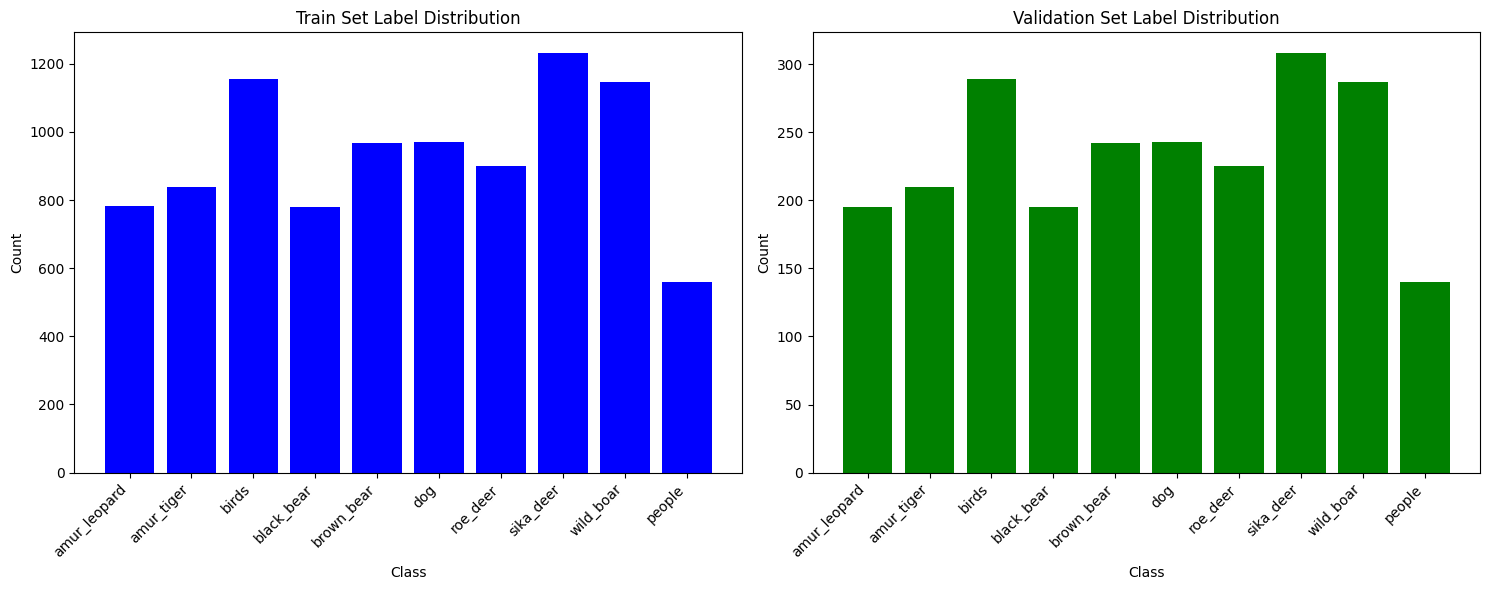

wandb:                                                                                
wandb: 🚀 View run stratified-split at: https://wandb.ai/cse508/Wildflife%20Project/runs/imgaf4pd
wandb: ⭐️ View project at: https://wandb.ai/cse508/Wildflife%20Project
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20250220_120333-imgaf4pd/logs


In [3]:
# Split into 80 20
train_df, val_df = train_test_split(df, test_size=0.2, random_state=2021354, stratify=df['label'])
print(f"Train set: {len(train_df)} samples, Validation set: {len(val_df)} samples")


# Define transforms with resize
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize all images to same dimensions
    transforms.ToTensor(),  # Convert to tensor
    
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        label = row['label']
        image = Image.open(image_path).convert("RGB")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Create datasets with the transforms
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)


# Initialize Weights & Biases (WandB)
wandb.init(project=WANDB_PROJECT, name="stratified-split")
wandb.config.batch_size = BATCH_SIZE

# Get label names from label_mapping (assuming you have this dictionary)
label_names = {v: k for k, v in label_mapping.items()}  # Reverse the mapping

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Compute the counts of each label in both splits
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

# Plot training set distribution
axs[0].bar(range(len(train_counts)), train_counts.values, color='blue')
axs[0].set_title("Train Set Label Distribution")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].set_xticks(range(len(train_counts)))
axs[0].set_xticklabels([label_names[i] for i in train_counts.index], rotation=45, ha='right')

# Plot validation set distribution
axs[1].bar(range(len(val_counts)), val_counts.values, color='green')
axs[1].set_title("Validation Set Label Distribution")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Count")
axs[1].set_xticks(range(len(val_counts)))
axs[1].set_xticklabels([label_names[i] for i in val_counts.index], rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Log the distribution plot to WandB
wandb.log({"Label Distribution": wandb.Image(fig, caption="Train and Validation Label Distribution")})
plt.close(fig)
wandb.finish()


In [4]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):  # 10 classes as per your label_mapping
        super(ConvNet, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size of flattened features
        # Assuming input image size is 224x224 (standard size)
        # After pool1 (4,4): 56x56
        # After pool2 (2,2): 28x28
        # After pool3 (2,2): 14x14
        self.flatten_size = 128 * 14 * 14
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Second block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Third block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classification head
        x = self.classifier(x)
        return x

# Initialize the model
model = ConvNet()

# If you have a GPU available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [5]:
# Initialize wandb
wandb.init(project=WANDB_PROJECT, name="cnn-training")
wandb.config.update({
    "batch_size": BATCH_SIZE,
    "epochs": 10,
    "learning_rate": optimizer.param_groups[0]['lr'],
    "model": "ConvNet"
})

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })
    
    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    
    torch.save(model.state_dict(), 'convnet.pth')



wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250220_120337-9s5zbcvl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cnn-training
wandb: ⭐️ View project at https://wandb.ai/cse508/Wildflife%20Project
wandb: 🚀 View run at https://wandb.ai/cse508/Wildflife%20Project/runs/9s5zbcvl


Epoch [1/10]
Train Loss: 1.9228, Train Acc: 29.57%
Val Loss: 1.5956, Val Acc: 44.60%
--------------------------------------------------
Epoch [2/10]
Train Loss: 1.5361, Train Acc: 46.79%
Val Loss: 1.4570, Val Acc: 50.21%
--------------------------------------------------
Epoch [3/10]
Train Loss: 1.2973, Train Acc: 55.15%
Val Loss: 1.1764, Val Acc: 59.04%
--------------------------------------------------
Epoch [4/10]
Train Loss: 1.1045, Train Acc: 62.15%
Val Loss: 1.1088, Val Acc: 62.13%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.9374, Train Acc: 67.77%
Val Loss: 1.0347, Val Acc: 65.00%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.7902, Train Acc: 72.83%
Val Loss: 0.9664, Val Acc: 69.45%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.6639, Train Acc: 77.04%
Val Loss: 0.9944, Val Acc: 67.44%
--------------------------------------------------
Epoch [8/10]
Train Loss: 0.5567, Train Acc: 80.8

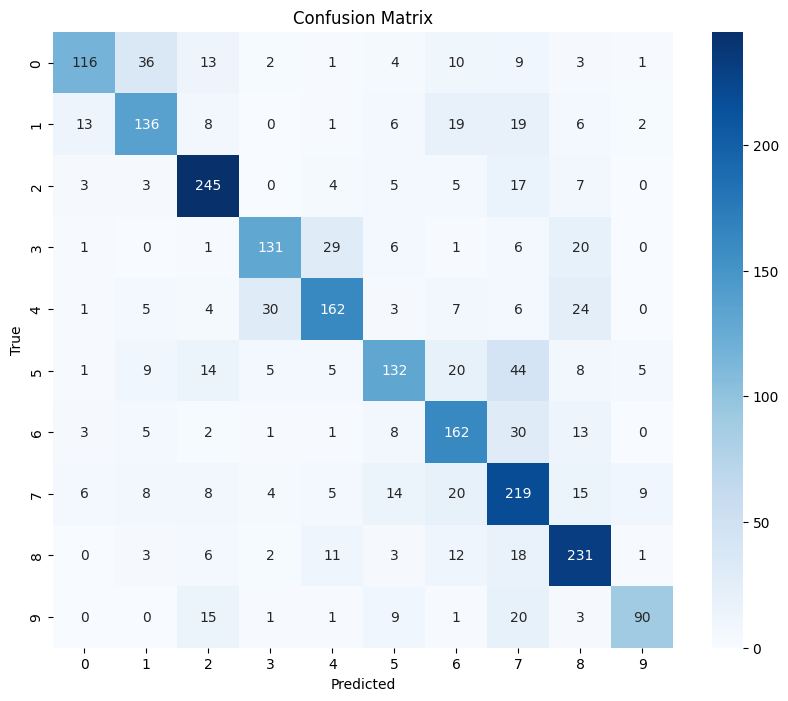

Validation Accuracy: 0.6958
Validation F1 Score: 0.6951


In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Create confusion matrix plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Log metrics to wandb
    wandb.log({
        "Validation Accuracy": accuracy,
        "Validation F1 Score": f1,
        "Confusion Matrix": wandb.Image(plt)
    })
    
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    
    plt.close()

# Run evaluation
evaluate_model(model, val_loader, device)


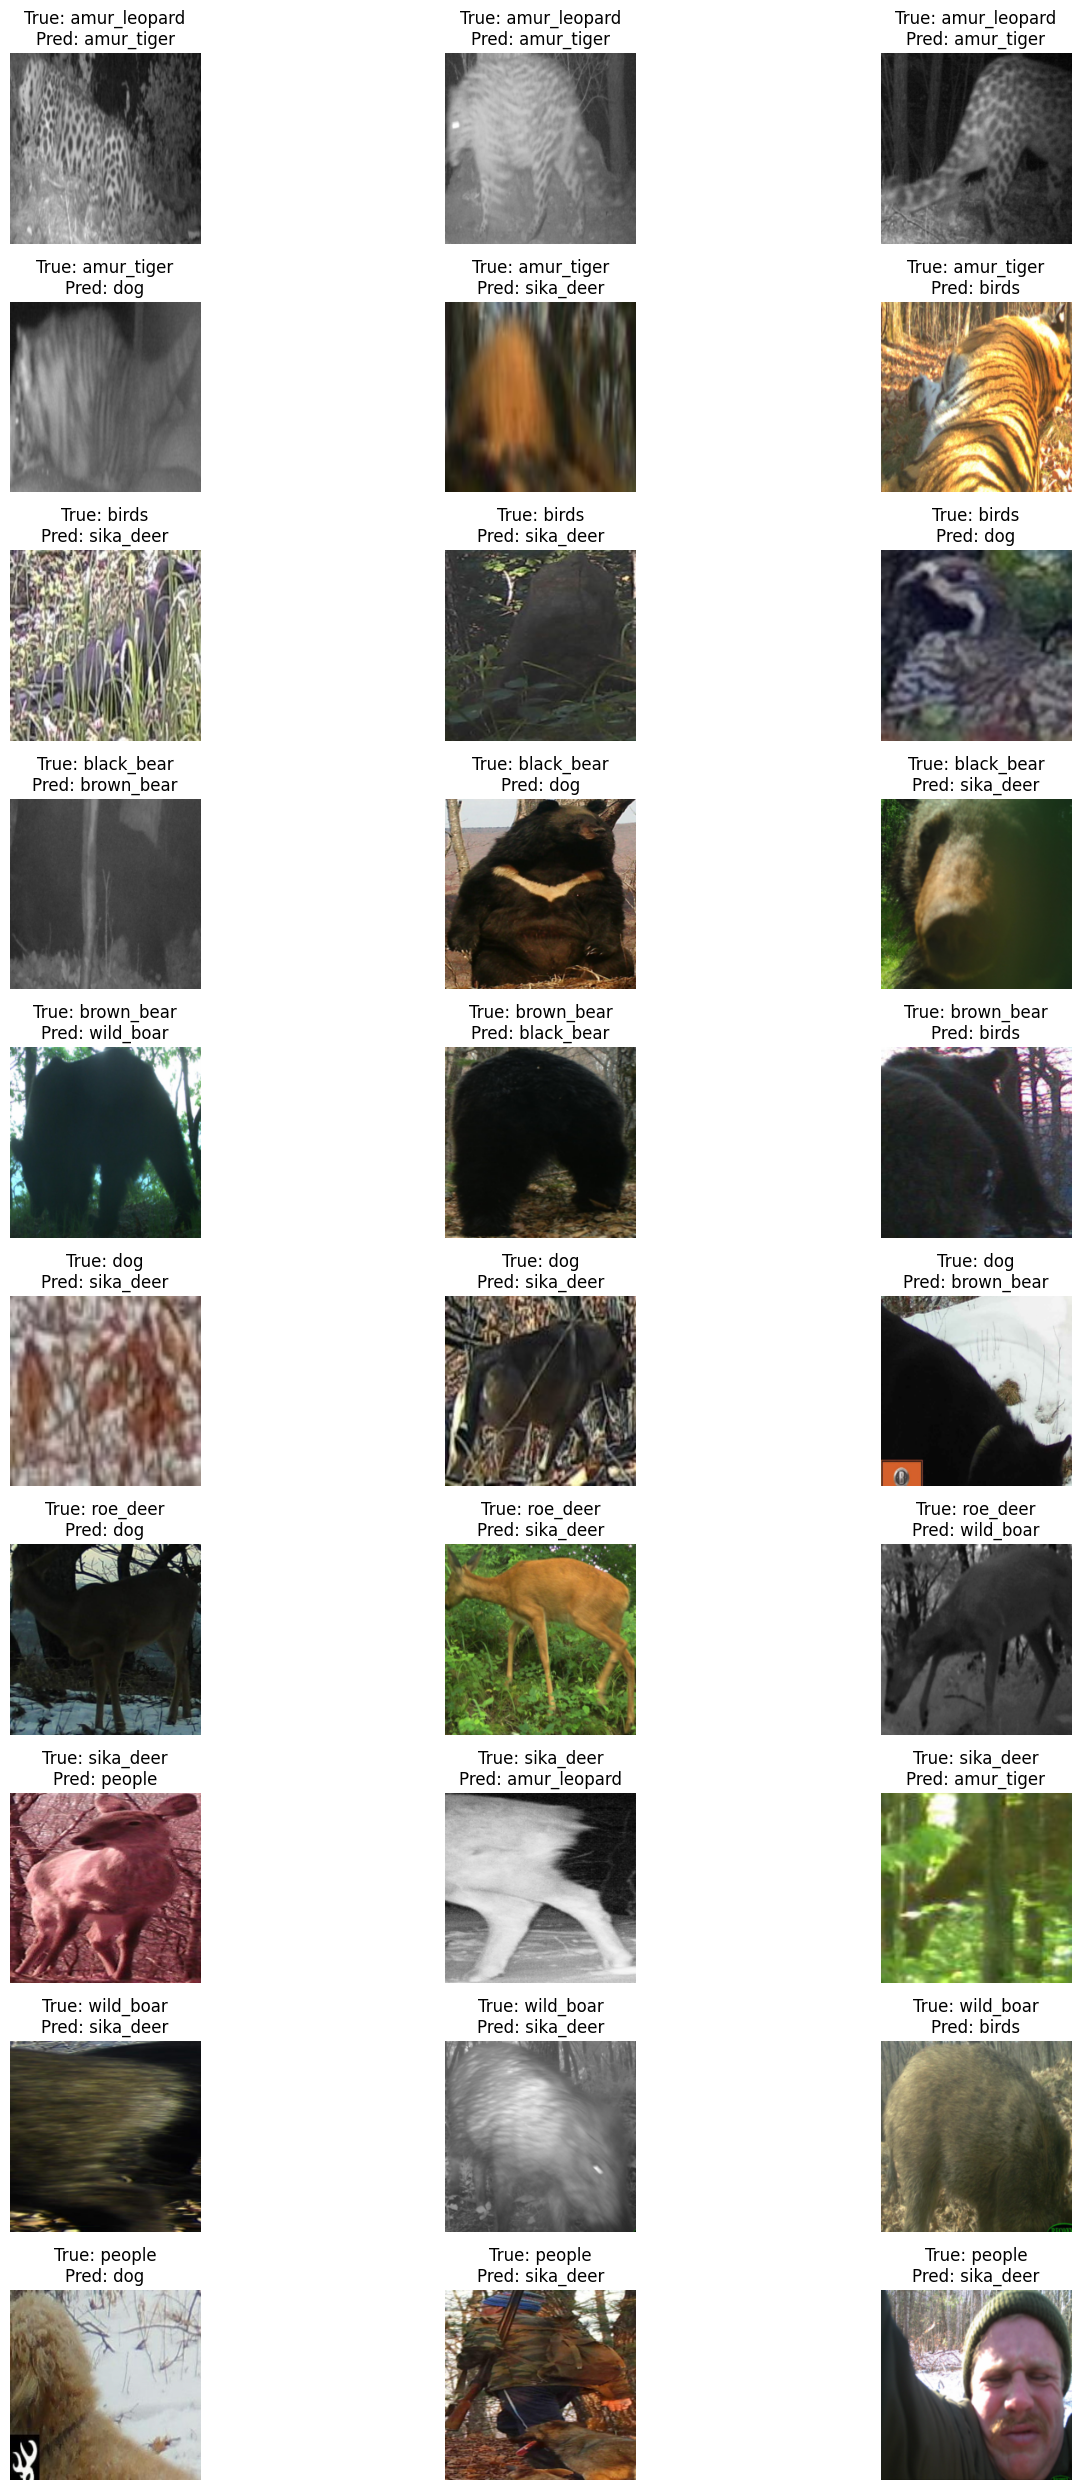


Confusion Analysis:

Class: amur_leopard
Misclassified as:
- amur_tiger: 3 times

Class: amur_tiger
Misclassified as:
- dog: 1 times
- sika_deer: 1 times
- birds: 1 times

Class: birds
Misclassified as:
- sika_deer: 2 times
- dog: 1 times

Class: black_bear
Misclassified as:
- brown_bear: 1 times
- dog: 1 times
- sika_deer: 1 times

Class: brown_bear
Misclassified as:
- wild_boar: 1 times
- black_bear: 1 times
- birds: 1 times

Class: dog
Misclassified as:
- sika_deer: 2 times
- brown_bear: 1 times

Class: roe_deer
Misclassified as:
- dog: 1 times
- sika_deer: 1 times
- wild_boar: 1 times

Class: sika_deer
Misclassified as:
- people: 1 times
- amur_leopard: 1 times
- amur_tiger: 1 times

Class: wild_boar
Misclassified as:
- sika_deer: 2 times
- birds: 1 times

Class: people
Misclassified as:
- dog: 1 times
- sika_deer: 2 times



wandb:                                                                                
wandb: 
wandb: Run history:
wandb: Validation Accuracy ▁
wandb: Validation F1 Score ▁
wandb:               epoch ▁▂▃▃▄▅▆▆▇█
wandb:      train_accuracy ▁▃▄▅▆▆▇▇██
wandb:          train_loss █▆▅▄▃▃▂▂▁▁
wandb:        val_accuracy ▁▂▅▆▆█▇▇██
wandb:            val_loss █▆▃▃▂▁▁▂▂▂
wandb: 
wandb: Run summary:
wandb: Validation Accuracy 0.6958
wandb: Validation F1 Score 0.69508
wandb:               epoch 10
wandb:      train_accuracy 86.20099
wandb:          train_loss 0.39552
wandb:        val_accuracy 69.58012
wandb:            val_loss 1.09373
wandb: 
wandb: 🚀 View run cnn-training at: https://wandb.ai/cse508/Wildflife%20Project/runs/9s5zbcvl
wandb: ⭐️ View project at: https://wandb.ai/cse508/Wildflife%20Project
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 3 other file(s)
wandb: Find logs at: ./wandb/run-20250220_120337-9s5zbcvl/logs


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import wandb

def get_misclassified_samples(model, val_loader, device, num_samples=3):
    model.eval()
    misclassified = {i: [] for i in range(10)}  # Dictionary for each class
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # Find misclassified samples
            mask = predicted != labels
            misclassified_indices = mask.nonzero().squeeze()
            
            for idx in misclassified_indices:
                true_label = labels[idx].item()
                pred_label = predicted[idx].item()
                
                # Store only if we need more samples for this class
                if len(misclassified[true_label]) < num_samples:
                    misclassified[true_label].append({
                        'image': images[idx].cpu(),
                        'true_label': true_label,
                        'pred_label': pred_label
                    })
    
    return misclassified

# Get class names (reverse of label_mapping)
class_names = {v: k for k, v in label_mapping.items()}

# Get misclassified samples
misclassified_samples = get_misclassified_samples(model, val_loader, device)

# Visualize misclassified samples for each class
fig = plt.figure(figsize=(15, 25))
for class_idx in range(10):
    samples = misclassified_samples[class_idx]
    
    for i, sample in enumerate(samples[:3]):
        plt.subplot(10, 3, class_idx * 3 + i + 1)
        # Convert tensor to image
        img = sample['image'].permute(1, 2, 0)  # Change from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(f'True: {class_names[sample["true_label"]]}\nPred: {class_names[sample["pred_label"]]}')
        plt.axis('off')

plt.tight_layout()

# Log the figure to wandb
wandb.log({"Misclassified Samples": wandb.Image(fig)})
plt.show()
plt.close()

# Analyze and log confusion patterns
confusion_analysis = ""
for class_idx, samples in misclassified_samples.items():
    if samples:
        confusion_analysis += f"\nClass: {class_names[class_idx]}\n"
        pred_counts = {}
        for sample in samples:
            pred_label = sample['pred_label']
            pred_class = class_names[pred_label]
            pred_counts[pred_class] = pred_counts.get(pred_class, 0) + 1
        
        confusion_analysis += "Misclassified as:\n"
        for pred_class, count in pred_counts.items():
            confusion_analysis += f"- {pred_class}: {count} times\n"

# Print and log confusion analysis
print("\nConfusion Analysis:")
print(confusion_analysis)

# Log confusion analysis to wandb as a text file
wandb.log({"confusion_analysis": wandb.Html(f"<pre>{confusion_analysis}</pre>")})
wandb.finish()

In [8]:
import torchvision.models as models

class FineTunedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(FineTunedResNet18, self).__init__()
        # Load pretrained ResNet-18
        self.model = models.resnet18(pretrained=True)
        
        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Replace the final layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        
        # Store the backbone (everything except the final layer)
        self.backbone = nn.Sequential(*list(self.model.children())[:-1])
    
    def forward(self, x):
        return self.model(x)
    
    def extract_features(self, x):
        # Get features before the final classification layer
        features = self.backbone(x)
        return features.view(features.size(0), -1)

# Initialize model, criterion, and optimizer
model = FineTunedResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Initialize wandb
wandb.init(project=WANDB_PROJECT, name="resnet18-finetuning")
wandb.config.update({
    "model": "ResNet18",
    "epochs": 10,
    "batch_size": BATCH_SIZE,
    "learning_rate": optimizer.param_groups[0]['lr']
})

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250220_121417-cneel0hg
wandb: Run `wandb offline` to turn off syncing.
wandb: Sync

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss/len(train_loader), 100.*correct/total

# Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Log metrics
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


    torch.save(model.state_dict(), 'resnet.pth')



Epoch [1/10]
Train Loss: 1.1446, Train Acc: 63.38%
Val Loss: 0.7545, Val Acc: 75.71%
Epoch [2/10]
Train Loss: 0.7642, Train Acc: 74.49%
Val Loss: 0.6528, Val Acc: 77.34%
Epoch [3/10]
Train Loss: 0.6758, Train Acc: 76.81%
Val Loss: 0.6316, Val Acc: 78.06%
Epoch [4/10]
Train Loss: 0.6219, Train Acc: 78.66%
Val Loss: 0.6171, Val Acc: 77.89%
Epoch [5/10]
Train Loss: 0.6041, Train Acc: 79.19%
Val Loss: 0.6196, Val Acc: 77.68%
Epoch [6/10]
Train Loss: 0.5826, Train Acc: 79.88%
Val Loss: 0.5584, Val Acc: 79.82%
Epoch [7/10]
Train Loss: 0.5609, Train Acc: 80.87%
Val Loss: 0.5609, Val Acc: 79.86%
Epoch [8/10]
Train Loss: 0.5438, Train Acc: 81.29%
Val Loss: 0.5659, Val Acc: 79.91%
Epoch [9/10]
Train Loss: 0.5319, Train Acc: 81.50%
Val Loss: 0.5358, Val Acc: 80.98%
Epoch [10/10]
Train Loss: 0.5289, Train Acc: 81.82%
Val Loss: 0.5693, Val Acc: 79.95%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:          epoch ▁▂▃▃▄▅▆▆▇█
wandb: train_accuracy ▁▅▆▇▇▇████
wandb:     train_loss █▄▃▂▂▂▁▁▁▁
wandb:   val_accuracy ▁▃▄▄▄▆▇▇█▇
wandb:       val_loss █▅▄▄▄▂▂▂▁▂
wandb: 
wandb: Run summary:
wandb:          epoch 10
wandb: train_accuracy 81.81916
wandb:     train_loss 0.52885
wandb:   val_accuracy 79.94859
wandb:       val_loss 0.56927
wandb: 
wandb: 🚀 View run resnet18-finetuning at: https://wandb.ai/cse508/Wildflife%20Project/runs/cneel0hg
wandb: ⭐️ View project at: https://wandb.ai/cse508/Wildflife%20Project
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250220_121417-cneel0hg/logs


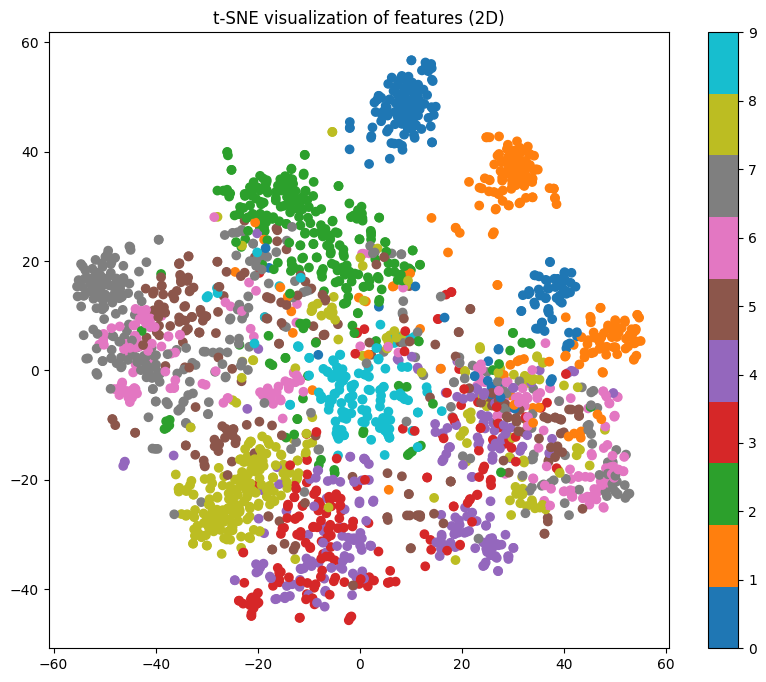

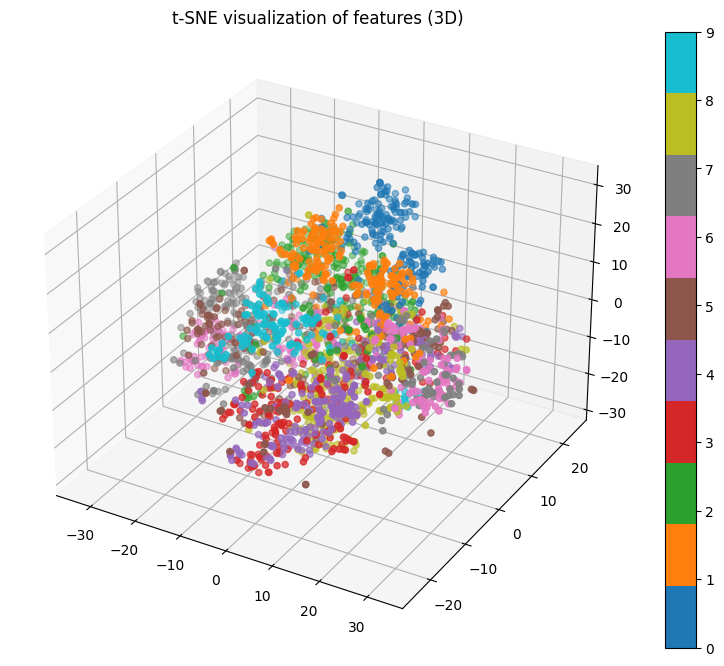

In [10]:
from sklearn.manifold import TSNE
import numpy as np

def extract_features_and_visualize(model, loader, device, dim=2):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for images, batch_labels in loader:
            images = images.to(device)
            batch_features = model.extract_features(images)
            features.append(batch_features.cpu())
            labels.append(batch_labels)
    
    features = torch.cat(features, 0).numpy()
    labels = torch.cat(labels, 0).numpy()
    
    # Apply t-SNE
    tsne = TSNE(n_components=dim, random_state=2021354)
    features_tsne = tsne.fit_transform(features)
    
    # Plot
    if dim == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                            c=labels, cmap='tab10')
        plt.colorbar(scatter)
        plt.title('t-SNE visualization of features (2D)')
        wandb.log({"TSNE_2D": wandb.Image(plt)})
    else:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                           features_tsne[:, 2], c=labels, cmap='tab10')
        plt.colorbar(scatter)
        plt.title('t-SNE visualization of features (3D)')
        wandb.log({"TSNE_3D": wandb.Image(plt)})

# Generate both 2D and 3D t-SNE plots
extract_features_and_visualize(model, val_loader, device, dim=2)
extract_features_and_visualize(model, val_loader, device, dim=3)

# Close wandb run
wandb.finish()

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250220_122427-mtbefowf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run augmented-data
wandb: ⭐️ View project at https://wandb.ai/cse508/Wildflife%20Project
wandb: 🚀 View run at https://wandb.ai/cse508/Wildflife%20Project/runs/mtbefowf


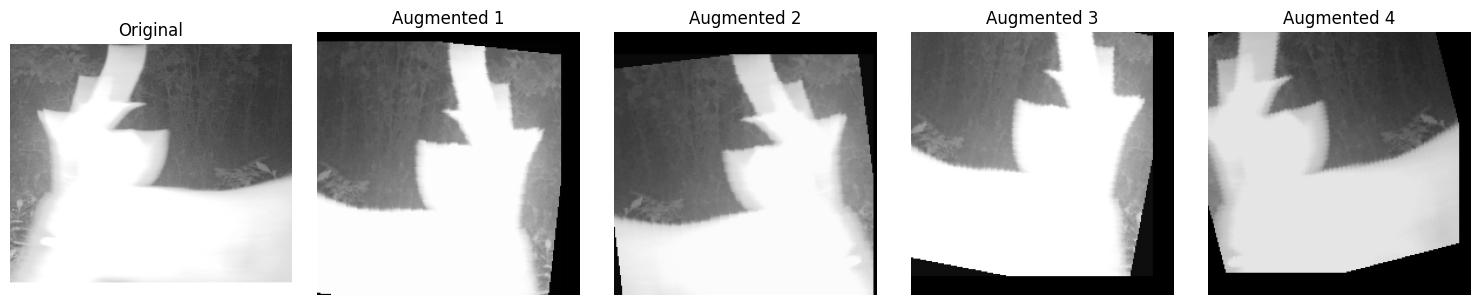

In [11]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

wandb.init(project=WANDB_PROJECT, name="augmented-data")

# Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with size variation
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomRotation(15),  # Random rotation up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor()
])

# Visualize augmentations
def visualize_augmentations(image_path, num_augmentations=5):
    # Load original image
    original_image = Image.open(image_path).convert('RGB')
    
    # Create subplot
    plt.figure(figsize=(15, 3))
    
    # Show original image
    plt.subplot(1, num_augmentations, 1)
    plt.imshow(original_image)
    plt.title('Original')
    plt.axis('off')
    
    # Show augmented images
    for i in range(num_augmentations-1):
        augmented_image = augmentation_transform(original_image)
        plt.subplot(1, num_augmentations, i+2)
        plt.imshow(augmented_image.permute(1, 2, 0))
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    wandb.log({"Augmentation Examples": wandb.Image(plt)})
    plt.show()

# Visualize augmentations for a sample image
sample_image_path = train_df['image_path'].iloc[0]  # Get first image path
visualize_augmentations(sample_image_path)

In [12]:
# Dataset with augmentation
class AugmentedImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        label = row['label']
        
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Create augmented datasets and dataloaders
train_dataset_aug = AugmentedImageDataset(train_df, transform=augmentation_transform)
val_dataset = AugmentedImageDataset(val_df, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [13]:
# Initialize new model, criterion, and optimizer
model_aug = FineTunedResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_aug.parameters())

# Initialize wandb
wandb.init(project=WANDB_PROJECT, name="resnet18-augmented")
wandb.config.update({
    "model": "ResNet18 with Augmentation",
    "epochs": 10,
    "batch_size": BATCH_SIZE,
    "learning_rate": optimizer.param_groups[0]['lr']
})

# Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_aug, train_loader_aug, criterion, optimizer, device)
    val_loss, val_acc = validate(model_aug, val_loader, criterion, device)
    
    # Log metrics
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    torch.save(model.state_dict(), 'resnet_aug.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10]
Train Loss: 1.3847, Train Acc: 54.33%
Val Loss: 0.9377, Val Acc: 67.99%
Epoch [2/10]
Train Loss: 0.9990, Train Acc: 66.68%
Val Loss: 0.8080, Val Acc: 71.81%
Epoch [3/10]
Train Loss: 0.9258, Train Acc: 68.88%
Val Loss: 0.7942, Val Acc: 72.24%
Epoch [4/10]
Train Loss: 0.8755, Train Acc: 69.36%
Val Loss: 0.7513, Val Acc: 73.31%
Epoch [5/10]
Train Loss: 0.8476, Train Acc: 70.23%
Val Loss: 0.7372, Val Acc: 73.56%
Epoch [6/10]
Train Loss: 0.8401, Train Acc: 71.04%
Val Loss: 0.7085, Val Acc: 74.94%
Epoch [7/10]
Train Loss: 0.8182, Train Acc: 71.36%
Val Loss: 0.7375, Val Acc: 73.69%
Epoch [8/10]
Train Loss: 0.8263, Train Acc: 71.36%
Val Loss: 0.7400, Val Acc: 73.95%
Epoch [9/10]
Train Loss: 0.8024, Train Acc: 72.26%
Val Loss: 0.6848, Val Acc: 76.31%
Epoch [10/10]
Train Loss: 0.8096, Train Acc: 72.19%
Val Loss: 0.7053, Val Acc: 74.72%
